In [6]:
%config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))



### General imports
import numpy as np
import matplotlib.pyplot as plt

plt.rc('figure',figsize=(16,10))
plt.rc('font',size=12)

In [7]:
def generate_gaussian_realization_2D(power_spectrum, grid_size, seed=None, grid_scale=1):
    """
    Generate a 2D Gaussian realization from a given power spectrum (Chat-GPT writtten).

    Parameters:
        power_spectrum (callable): A function P(kx, ky) that defines the power spectrum as a function of kx and ky.
        grid_size (int): The size of the 2D grid (grid_size x grid_size).
        seed (int, optional): Seed for random number generation.

    Returns:
        np.ndarray: A 2D Gaussian realization.
    """
    if seed is not None:
        np.random.seed(seed)

    # Create the kx, ky grids
    kx = np.fft.fftfreq(grid_size) * grid_size * grid_scale
    ky = np.fft.fftfreq(grid_size) * grid_size * grid_scale
    kx, ky = np.meshgrid(kx, ky)

    # Compute the amplitude of the Fourier modes using the power spectrum
    amplitude = np.sqrt(power_spectrum(kx, ky))

    # Generate random Fourier coefficients
    real_part = np.random.normal(0, 1, (grid_size, grid_size))
    imag_part = np.random.normal(0, 1, (grid_size, grid_size))
    fourier_modes = amplitude * (real_part + 1j * imag_part)

    # Enforce Hermitian symmetry to ensure the result is real
    #fourier_modes = (fourier_modes + np.conj(np.flip(np.flip(fourier_modes, axis=0), axis=1))) / 2

    # Perform the inverse Fourier transform to get the 2D realization
    gaussian_realization = np.fft.ifft2(fourier_modes).real

    return gaussian_realization


# Define an example power spectrum
def example_power_spectrum(kx, ky):
    k2 = kx**2 + ky**2
    return np.exp(-k2 / 10.0)  # Gaussian power spectrum for demonstration

def kolmogorov_power_spectrum(kx, ky, k0=1, power=-8/3):
    """
    Kolmogorov power spectrum with a power law.

    Parameters:
        kx (np.ndarray): The wave numbers in the x-direction.
        ky (np.ndarray): The wave numbers in the y-direction.
        k0 (float, optional): The smallest wave number (injection scale) to avoid singularity at k=0. Default is 1.

    Returns:
        np.ndarray: The power spectrum values for the given kx and ky.
    """
    # Compute the wave number magnitude
    k2 = kx**2 + ky**2
    k = np.sqrt(k2)

    # Avoid division by zero at k=0 by setting a minimum cutoff at k0
    k = np.maximum(k, k0)

    # Kolmogorov power spectrum proportional to k^power
    return k**power


def pointing(nn, dx, dy, x0, y0, nscans=10):
    ptgx = x0 + dx * np.sin(nscans * np.linspace(0,1,nn)*2*np.pi)
    ptgy = y0 + np.linspace(0, dy, nn)
    return ptgx, ptgy

(512,)


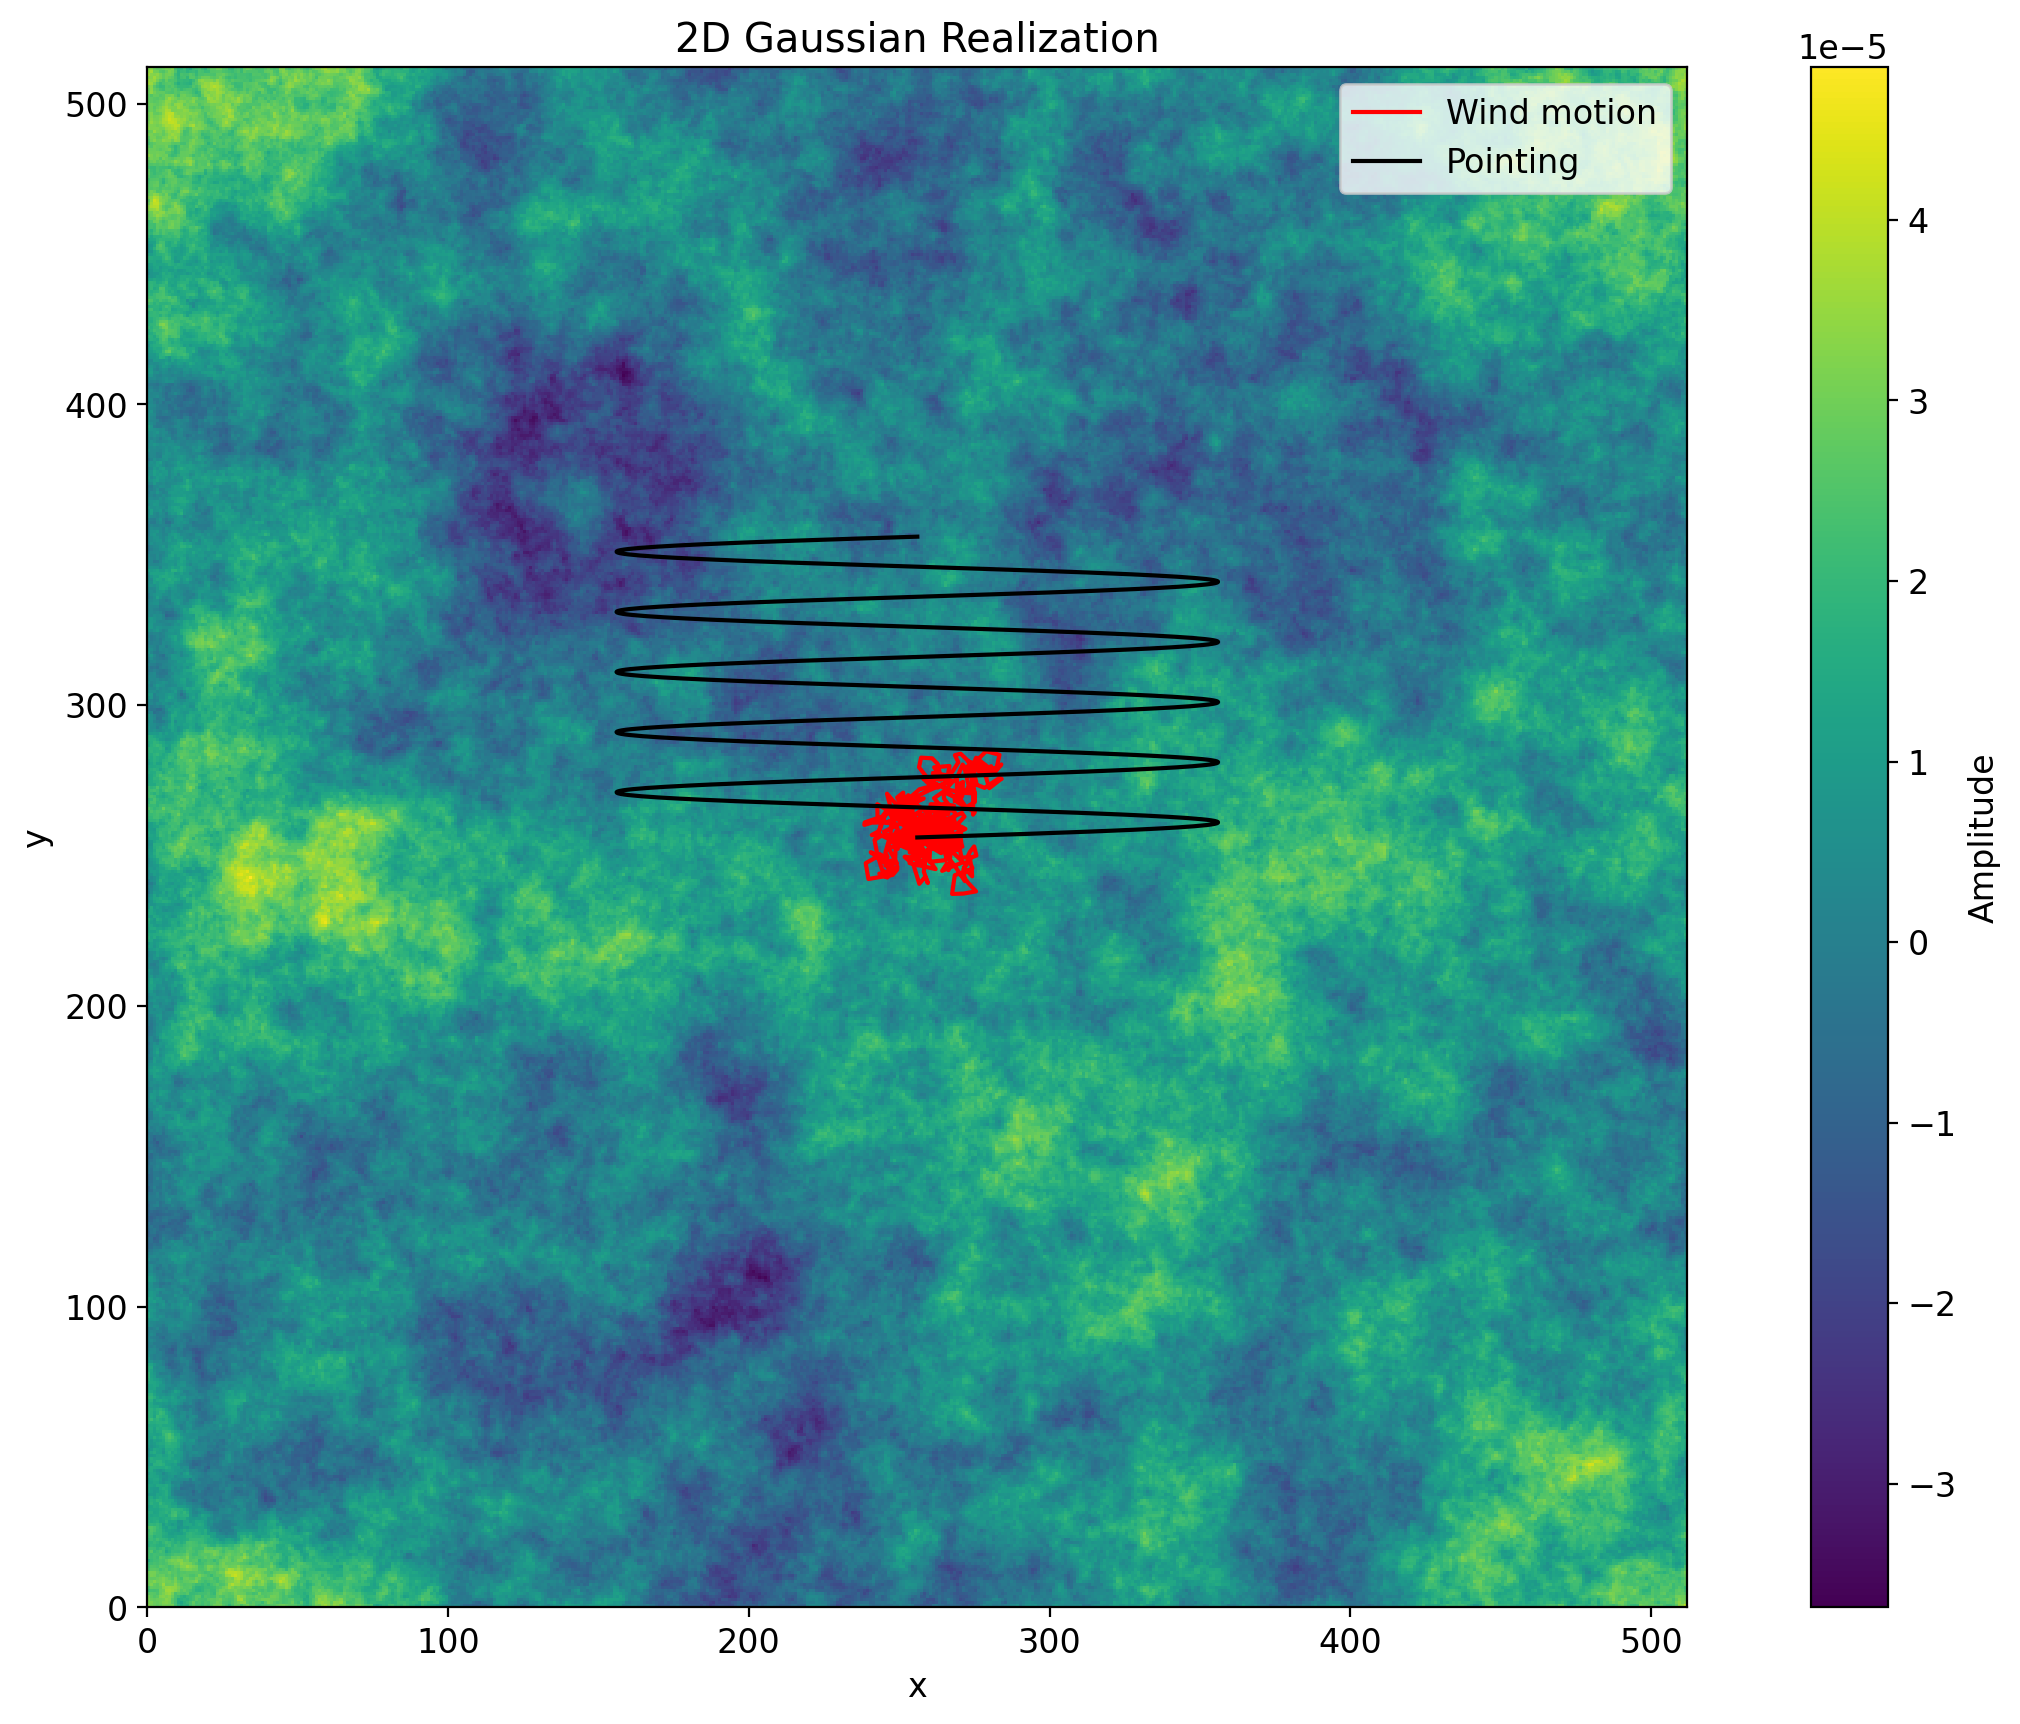

In [ ]:
grid_size = 512
seed = None

x0, y0 = grid_size//2, grid_size//2

realization = generate_gaussian_realization_2D(kolmogorov_power_spectrum, grid_size, seed, grid_scale=1)

ptgx, ptgy = pointing(grid_size, 100, 100, x0, y0, nscans=5)

wind_rms = 10
windx = realization[np.random.randint(grid_size),:]
windx = windx * (wind_rms / np.std(windx))
windy = realization[np.random.randint(grid_size),:]
windy = windy * (wind_rms / np.std(windy))

# Plot the realization
plt.figure()
plt.imshow(realization, origin='lower', extent=(0, grid_size, 0, grid_size), cmap='viridis')
plt.plot(windx + x0, windy + y0, 'r', label='Wind motion')
plt.plot(ptgx, ptgy, 'k', label='Pointing')
plt.colorbar(label='Amplitude')
plt.title('2D Gaussian Realization')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

[[260 261]
 [266 261]
 [272 260]
 ...
 [248 359]
 [255 359]
 [261 360]]


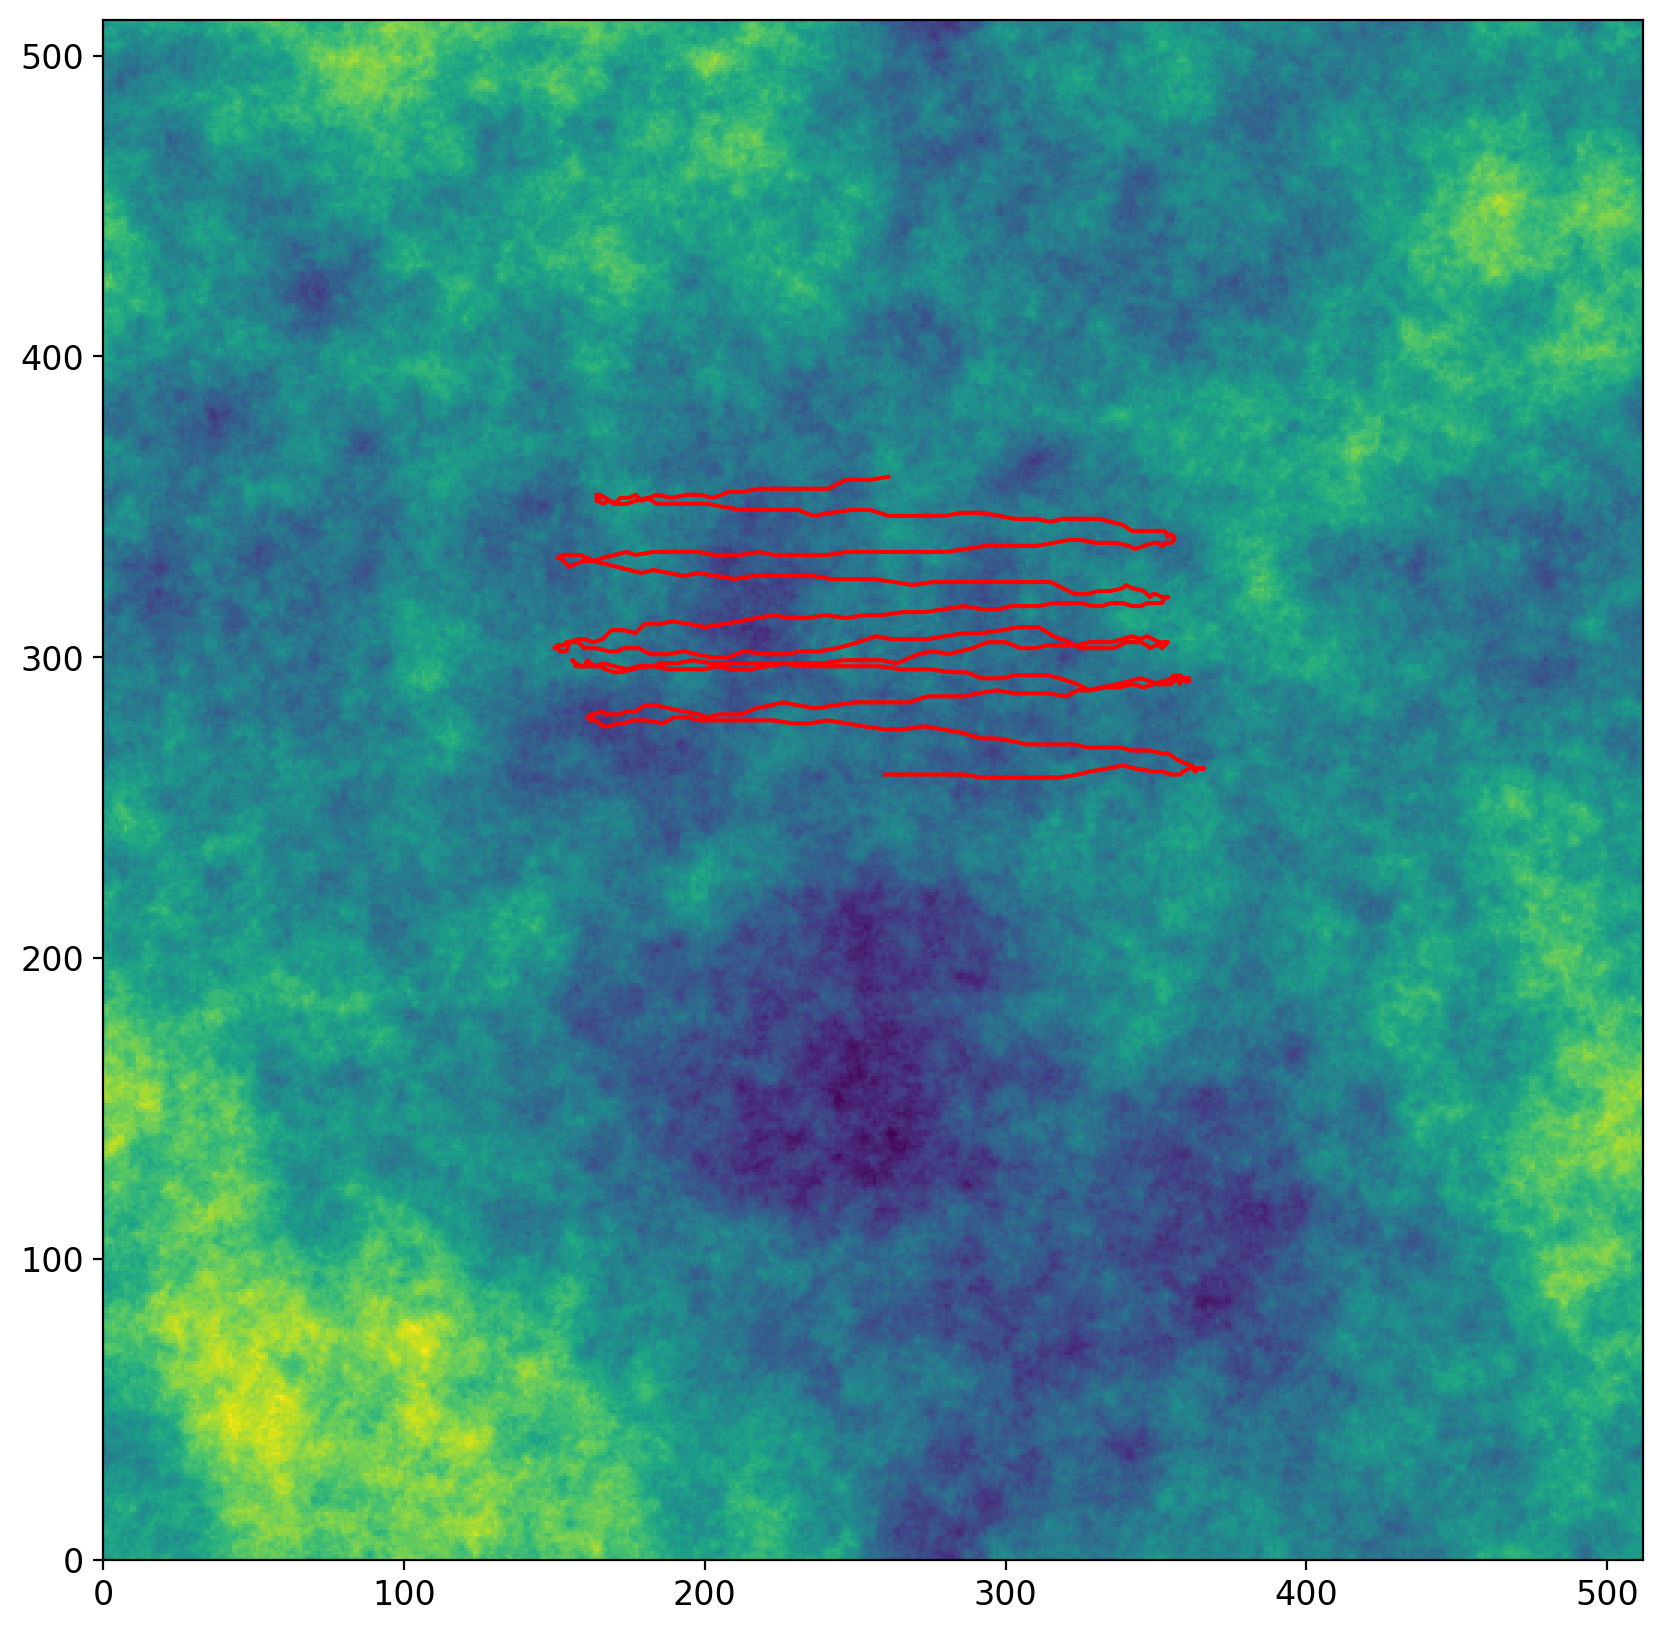

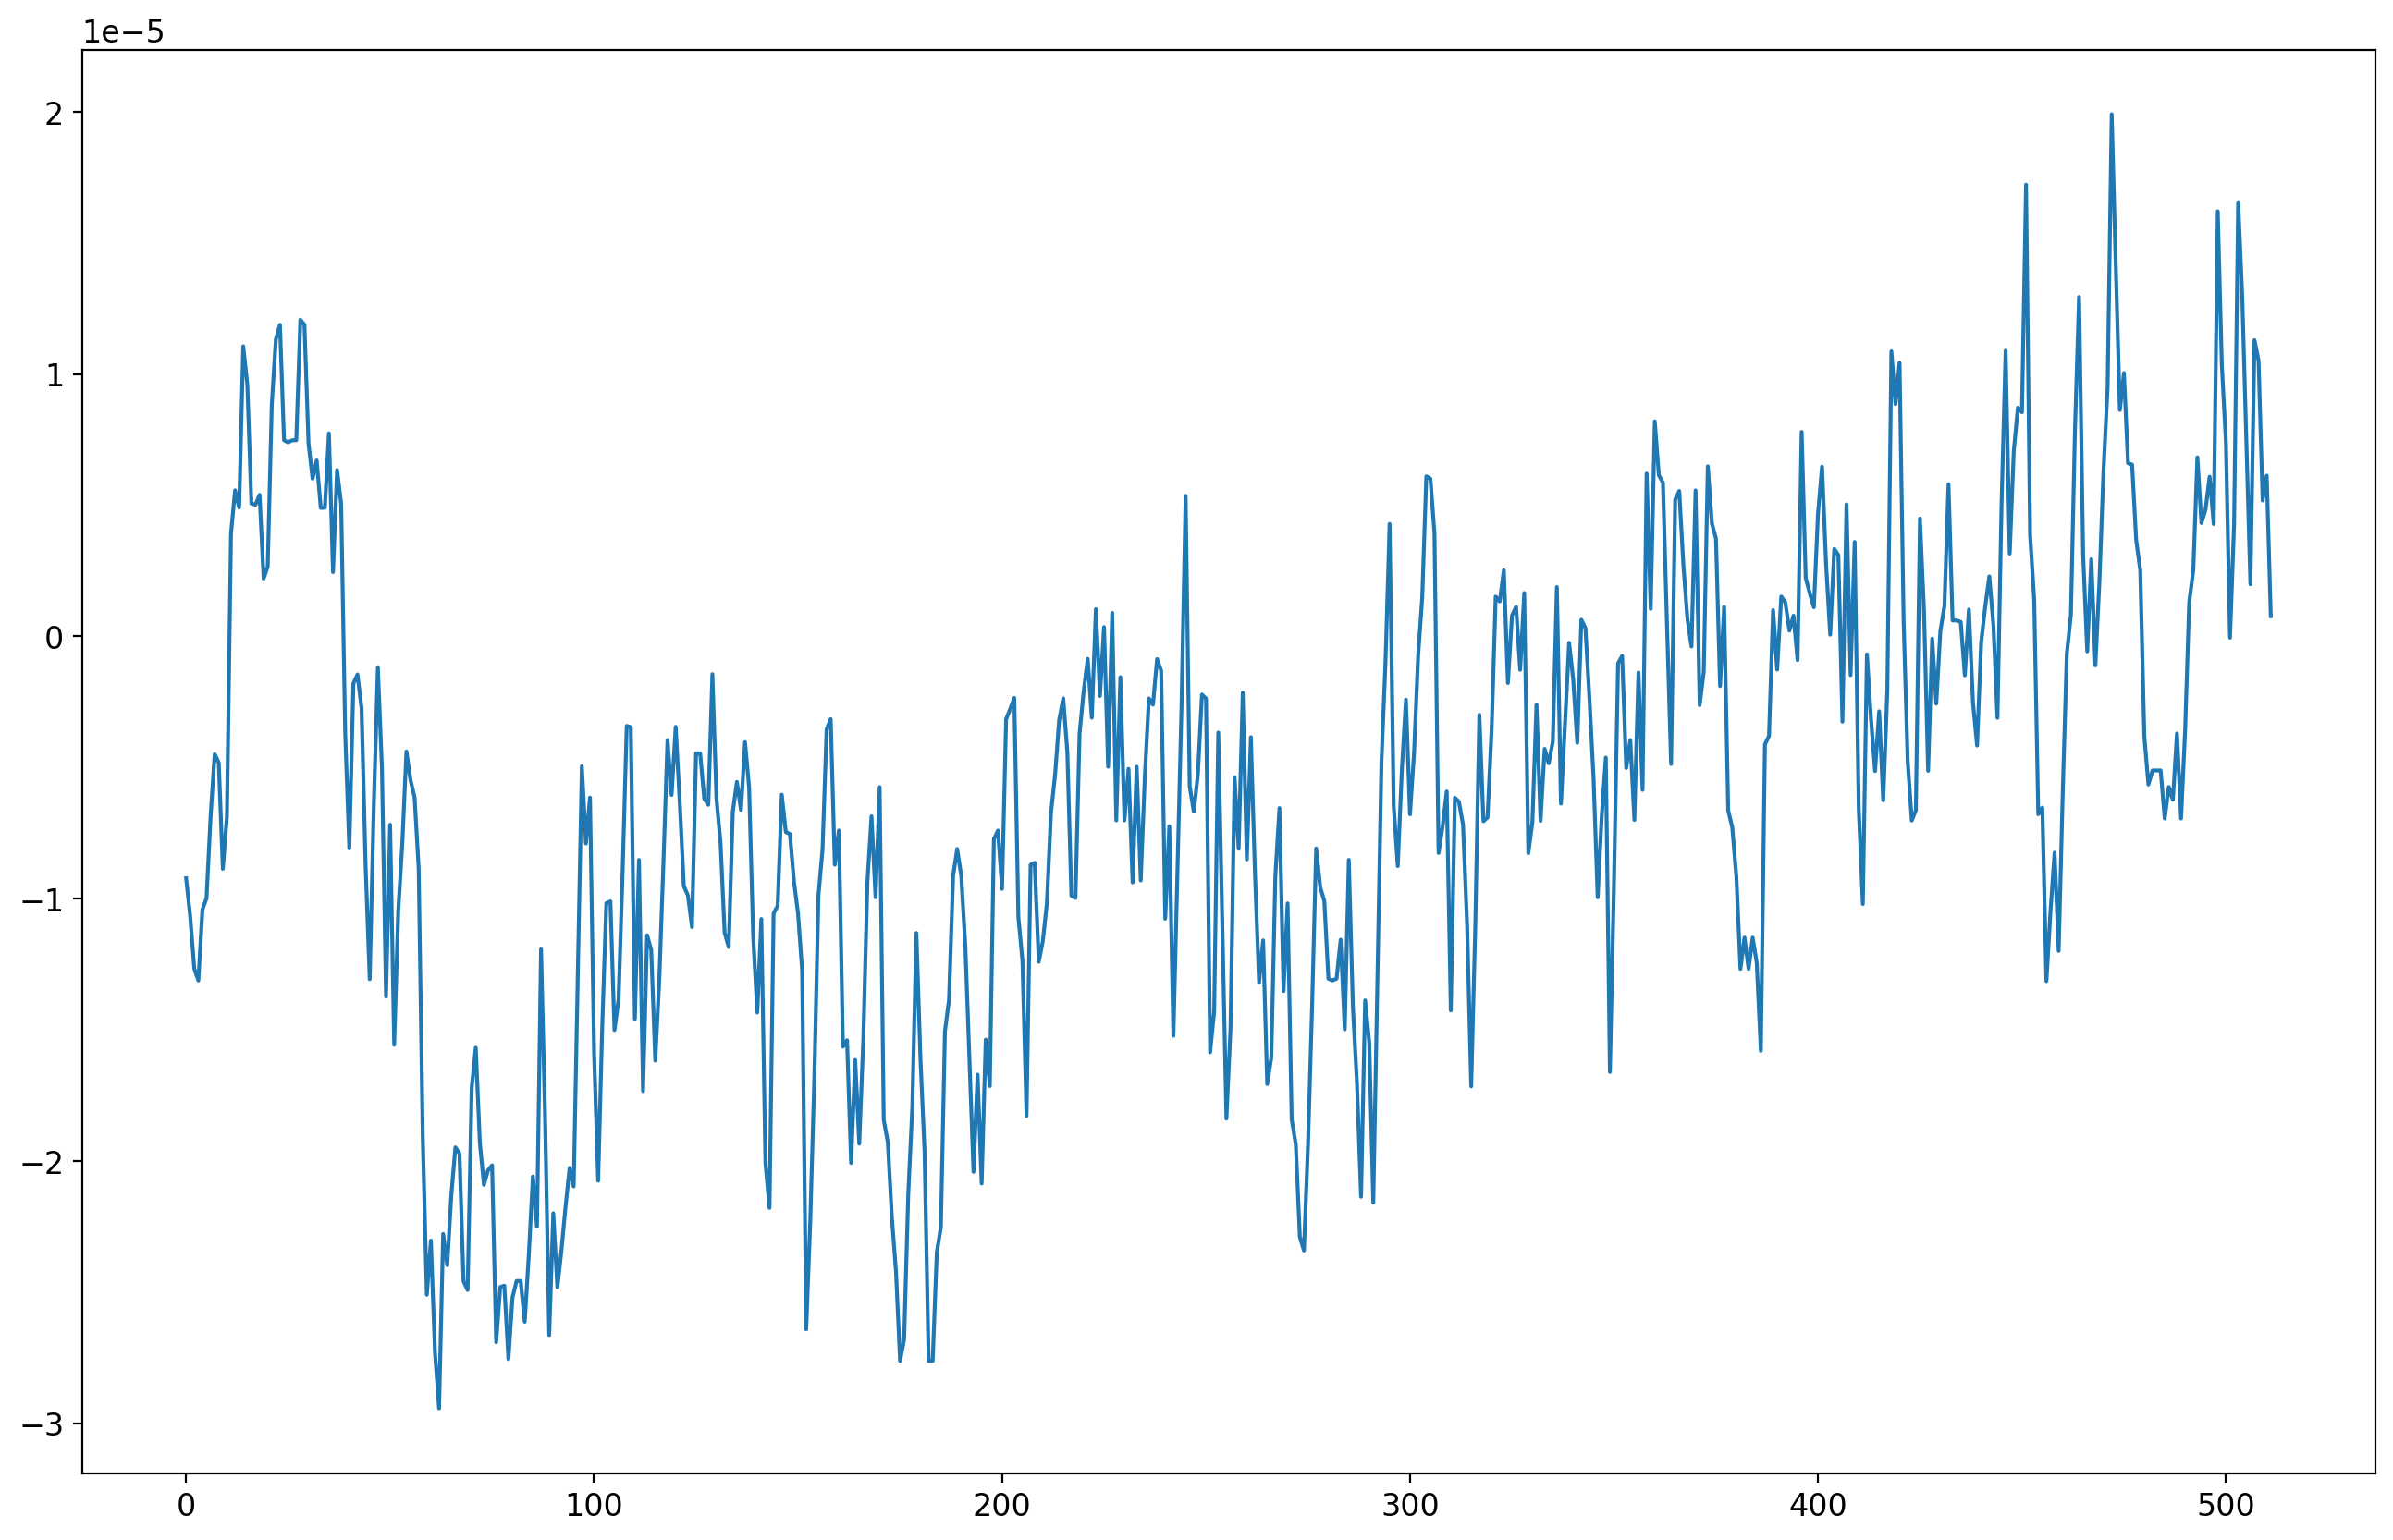

In [9]:
#### Method 1
### Actual pixel pointed at

def get_signal_direct(ptgx, ptgy, windx, windy, mymap):
    mypix_x = (np.round(windx)+np.round(ptgx)).astype(int)
    mypix_y = (np.round(windy)+np.round(ptgy)).astype(int)
    print(np.array([mypix_x, mypix_y]).T)
    return mymap[mypix_x, mypix_y]

mypix_x = np.round(windx+ptgx).astype(int)
mypix_y = np.round(windy+ptgy).astype(int)
plt.figure()
plt.imshow(realization, origin='lower', extent=(0, grid_size, 0, grid_size), cmap='viridis')
plt.plot(mypix_x, mypix_y, 'r', label='pointed pixel')


#%timeit toto = get_signal_direct(ptgx, ptgy, windx, windy, realization)
signal = get_signal_direct(ptgx, ptgy, windx, windy, realization)
plt.figure()
plt.plot(signal)

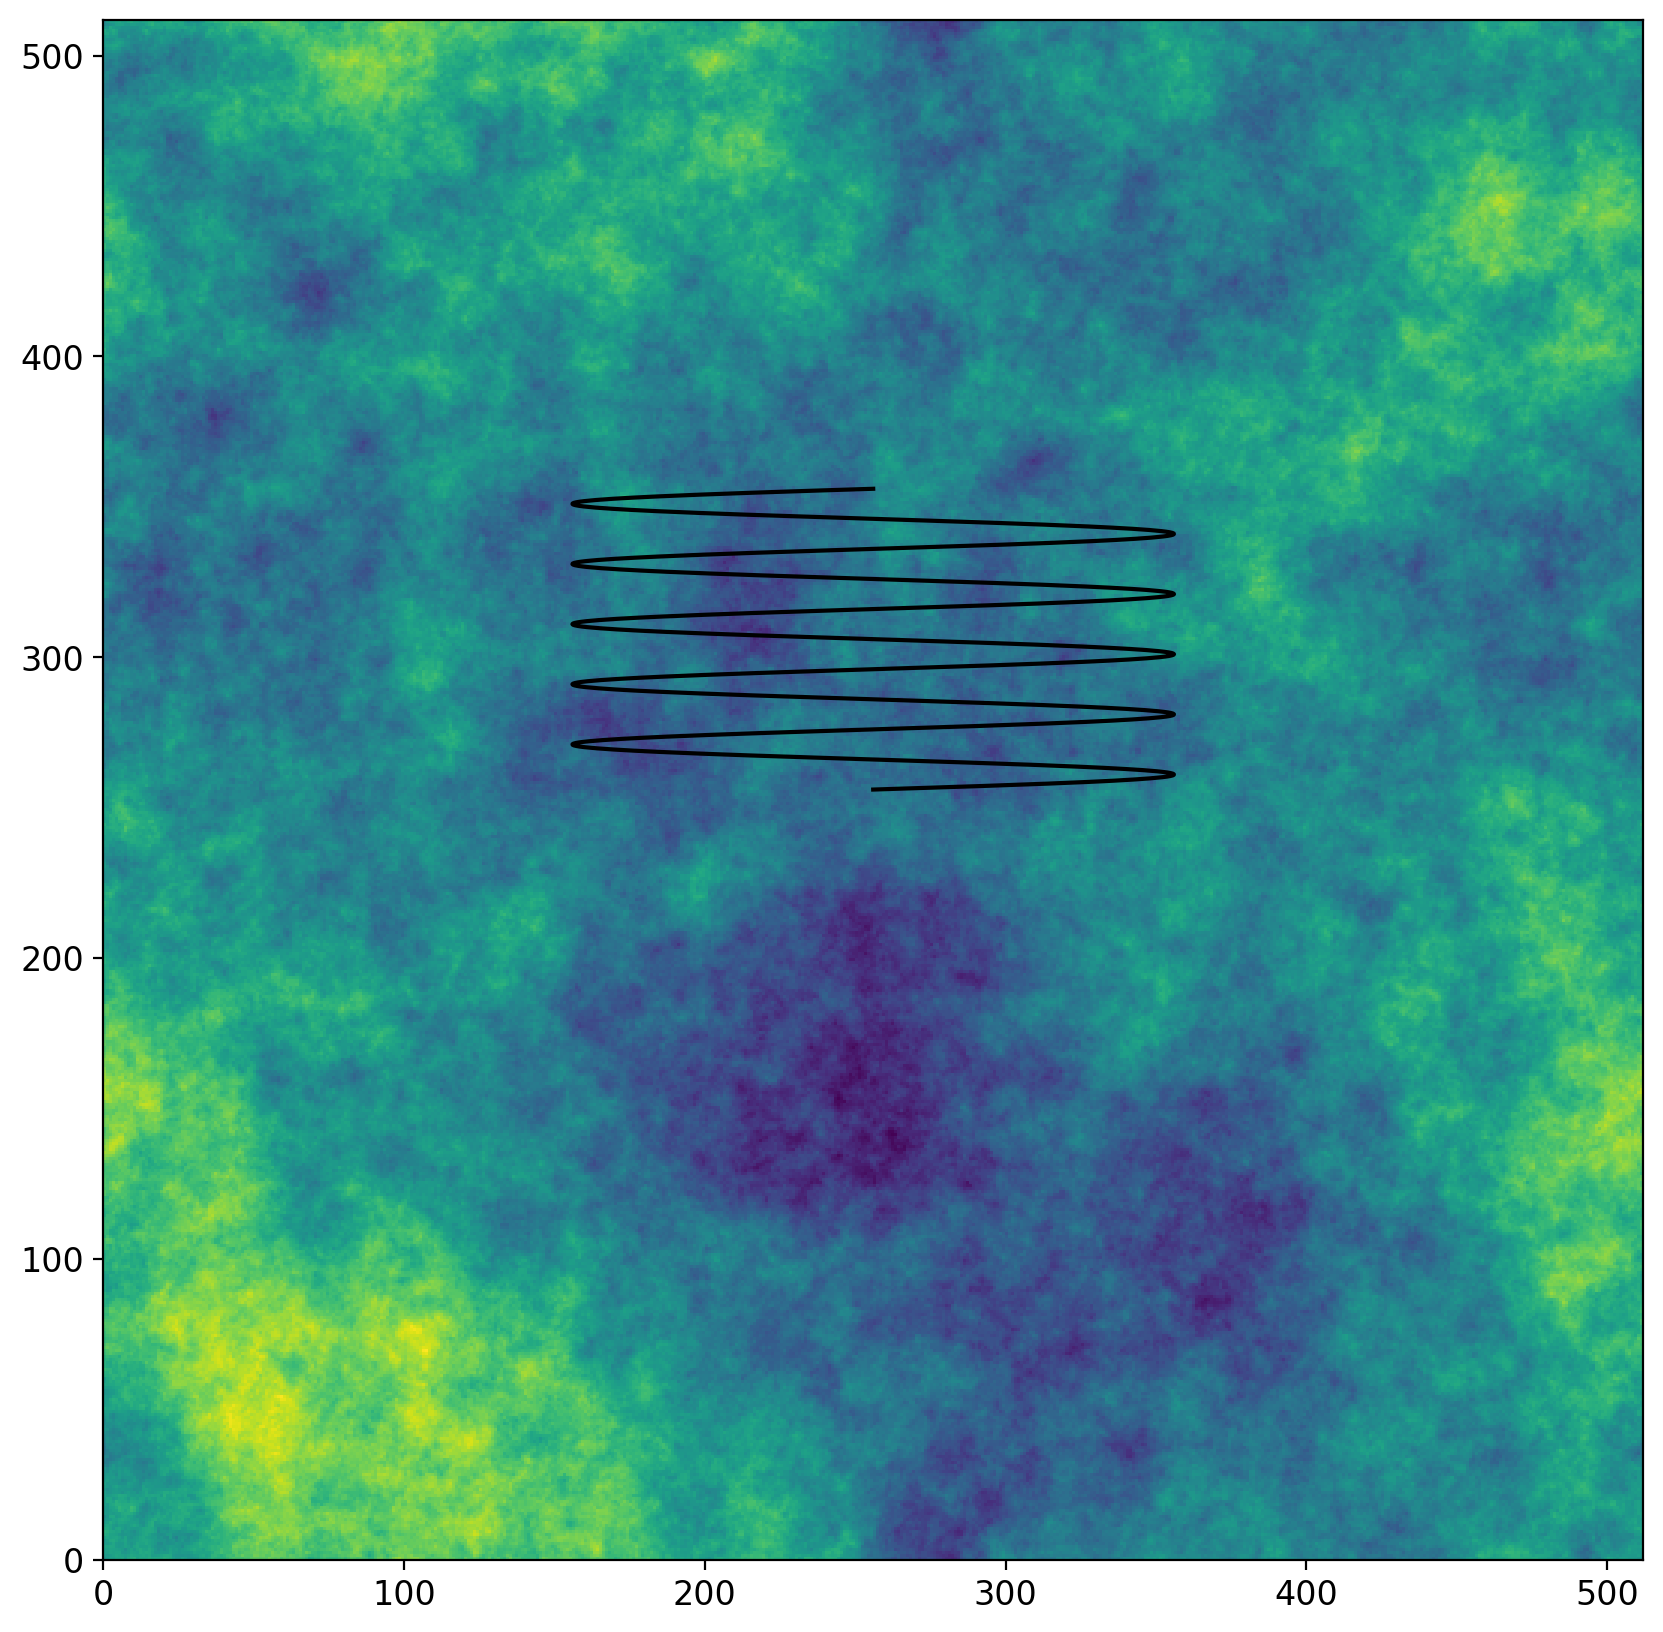

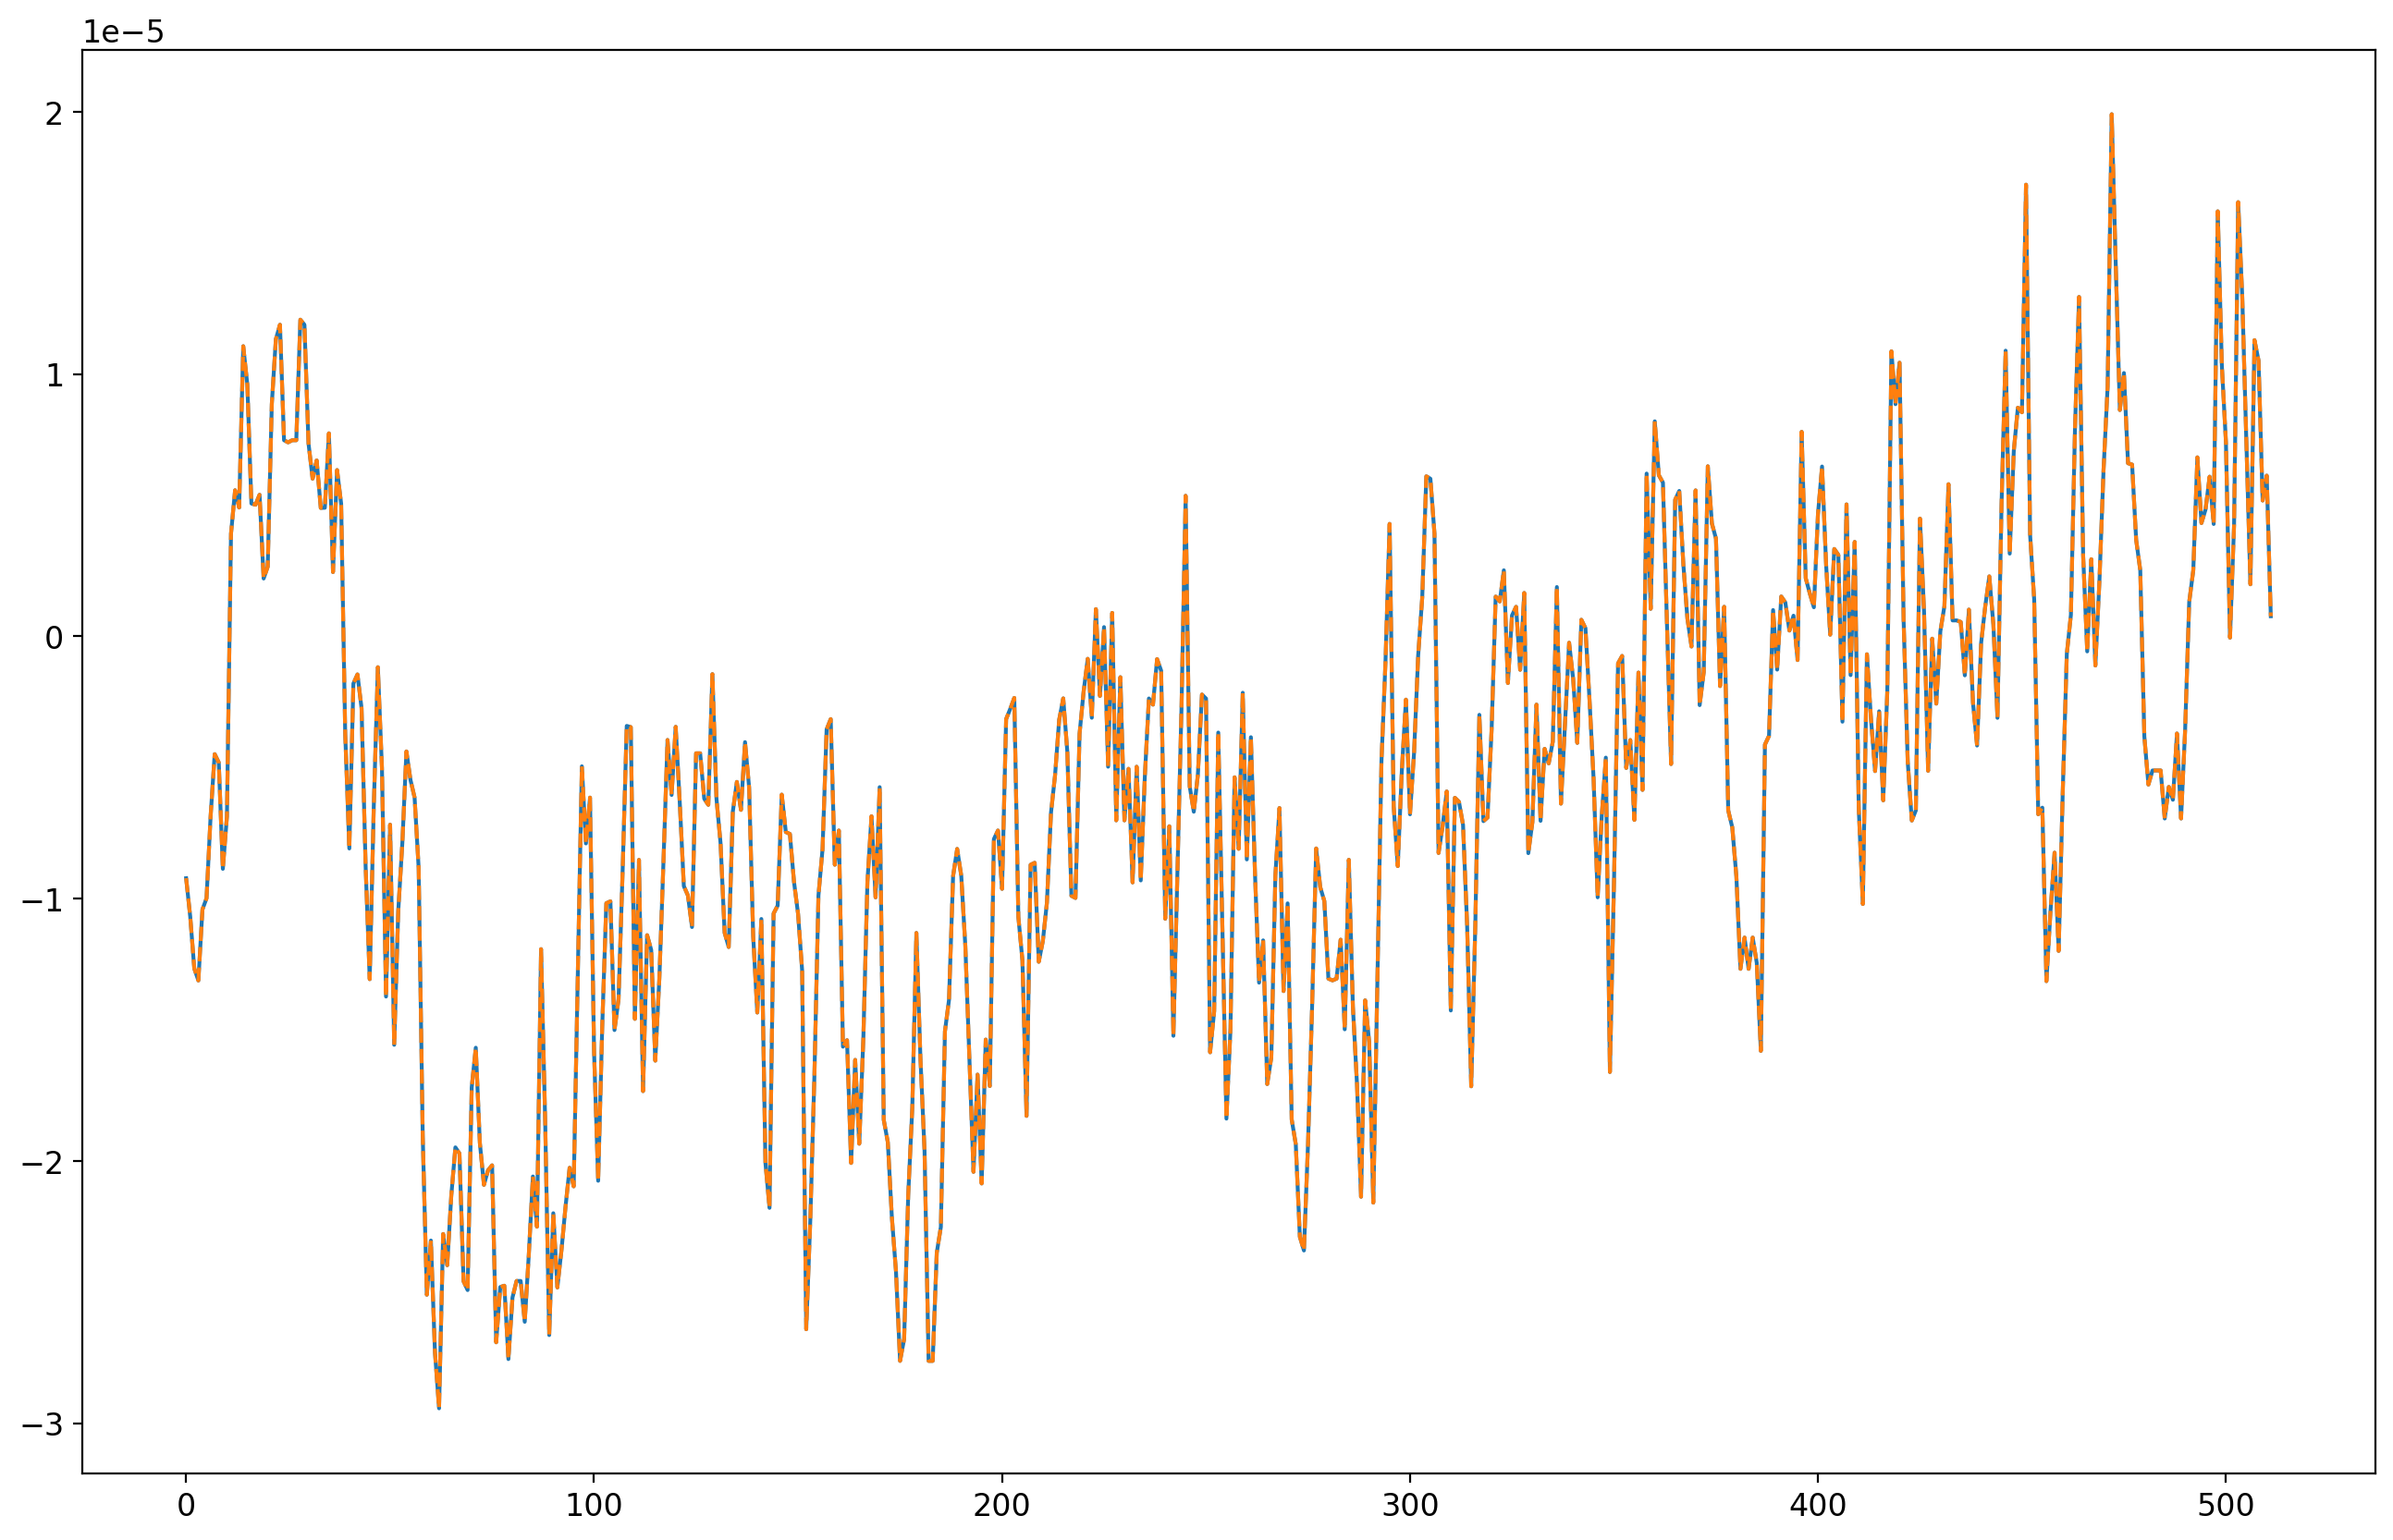

In [10]:
#### Method 2 point as usual but shifting the atmospheric map

def get_signal_shiftmap(ptgx, ptgy, windx, windy, mymap):
    mypix_x = np.round(ptgx).astype(int)
    mypix_y = np.round(ptgy).astype(int)
    data = np.zeros(len(windx))
    for i in range(len(windx)):
        dx = -np.round(windx[i]).astype(int)
        dy = -np.round(windy[i]).astype(int)
        #print(dx, dy, dx+x0, dy+y0, mypix_x[i], mypix_y[i])
        data[i] = np.roll(mymap, (dx, dy), axis=(0,1))[mypix_x[i], mypix_y[i]]
    return data


plt.figure()
plt.imshow(realization, origin='lower', extent=(0, grid_size, 0, grid_size), cmap='viridis')
plt.plot(ptgx, ptgy, 'k', label='pointed pixel')

#%timeit toto = get_signal_shiftmap(ptgx, ptgy, windx, windy, realization)
signal_shift = get_signal_shiftmap(ptgx, ptgy, windx, windy, realization)
plt.figure()
plt.plot(signal_shift)
plt.plot(signal,'--')
